In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.utils import plot_model

In [3]:
folder_path = r'data/'
csv_path = folder_path + 'Fulldata_age.csv'
df = pd.read_csv(csv_path)

Mounted at /content/drive
Fulldata.csv
Fulldata_age.csv
ergebnisse_grid.csv
ergebnisse_rand.csv
ergebnisse_rand_1.csv
ergebnisse_reg_NC.csv
ergebnisse_reg_SoH.csv
ergebnisse_reg.csv
ergebnisse_best.csv
pred_linreg_SoH.csv
pred_linreg_NC.csv
pred_best.csv
BPW_CSV
BPW_CSV_2
ergebnisse_best_1.csv
test_best.csv
model_plot.png


In [4]:
full_df = df.sample(frac=1, random_state=42)
full_df.info()
train_df = full_df.copy()
train_df = train_df[train_df['Value_SoH'] > 0.79]
#train_df = train_df[train_df['Folder'] == 1]
#Dropable Columns
training_columns = ['Time','Value_U','Value_I','Value_SoC','Value_SoH','Cumulative_Ah','Value_Age','Value_NumCharge','Value_NcT80']
meta_columns = ['Value_Age','Folder']
#training_columns = ['Value_SoH','Cumulative_Ah','Value_Age','Value_NumCharge','Value_NcT80']
meta_df = train_df[meta_columns]
train_df = train_df[training_columns]
train_df.info()
train_df.head()

#Prediciton Columns
pred_columns = ['Value_SoH','Value_NcT80']
#pred_columns = ['Value_SoH']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1877898 entries, 119162 to 121958
Data columns (total 17 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Time             int64  
 1   Value_U          float64
 2   Value_I          float64
 3   Value_SoC        float64
 4   Value_State      int64  
 5   Value_SoH        float64
 6   Time_Diff        float64
 7   Value_Ah         float64
 8   Value_kWh        float64
 9   Cumulative_Ah    float64
 10  Cumulative_kWh   float64
 11  Value_Age        int64  
 12  Value_NumCharge  int64  
 13  AhpSoC           float64
 14  Folder           int64  
 15  Value_AgeT80     float64
 16  Value_NcT80      float64
dtypes: float64(12), int64(5)
memory usage: 257.9 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609468 entries, 119162 to 121958
Data columns (total 9 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Time             1609468 non-null  int64  


Value_SoH
Time              -0.003706
Value_U           -0.021728
Value_I            0.022917
Value_SoC         -0.003695
Value_SoH          1.000000
Cumulative_Ah     -0.907365
Value_Age         -0.728261
Value_NumCharge   -0.823077
Value_NcT80        0.864631
Name: Value_SoH, dtype: float64
Value_NcT80
Time              -0.100486
Value_U           -0.123829
Value_I            0.020746
Value_SoC         -0.073512
Value_SoH          0.864631
Cumulative_Ah     -0.687141
Value_Age         -0.743512
Value_NumCharge   -0.565780
Value_NcT80        1.000000
Name: Value_NcT80, dtype: float64


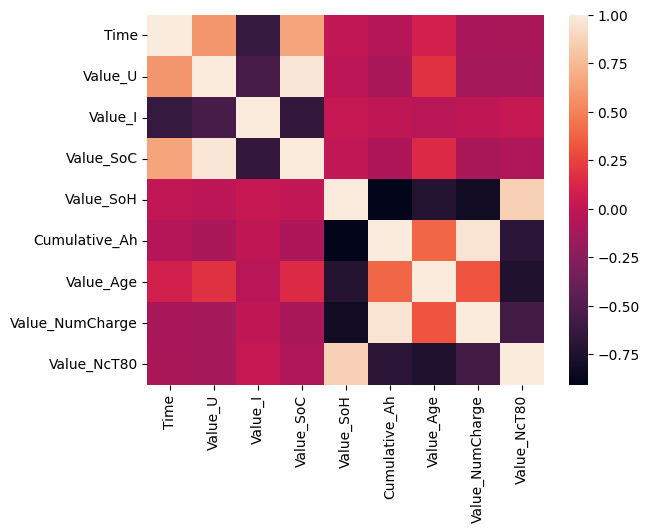

In [5]:
corr = train_df.corr()
fig, ax = plt.subplots()
sns.heatmap(corr)
for col in pred_columns:
  print(col)
  print(corr[col])


In [6]:
from sklearn.model_selection import train_test_split

X = dict()
y = dict()
X_train = dict()
meta =dict()
X_test = dict()
y_train = dict()
y_test = dict()
y_pred = dict()

In [7]:
X = train_df.drop(pred_columns,axis=1)
y_columns = pred_columns
y = train_df[y_columns]
print(y.shape,X.shape)



#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['Value_Age'])
X_train, X_test, y_train, y_test, meta_train, meta_test = train_test_split(X, y, meta_df,  test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val, meta_test, meta_val = train_test_split(X_test, y_test, meta_test, test_size=0.5, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train.info()
y_train.info()
meta_train.info()

(1609468, 2) (1609468, 7)
(1126627, 7) (241420, 7) (1126627, 2) (241420, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1126627 entries, 1802387 to 1391191
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Time             1126627 non-null  int64  
 1   Value_U          1126627 non-null  float64
 2   Value_I          1126627 non-null  float64
 3   Value_SoC        1126627 non-null  float64
 4   Cumulative_Ah    1126627 non-null  float64
 5   Value_Age        1126627 non-null  int64  
 6   Value_NumCharge  1126627 non-null  int64  
dtypes: float64(4), int64(3)
memory usage: 68.8 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1126627 entries, 1802387 to 1391191
Data columns (total 2 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Value_SoH    1126627 non-null  float64
 1   Value_NcT80  1126627 non-null  float64
dtypes: float64(2)
memory usa

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)
y_val_scaled = scaler_y.transform(y_val)

In [10]:

def train_model_test(layer_layout):
    seed_value = 42
    np.random.seed(seed_value)
    random.seed(seed_value)
    tf.random.set_seed(seed_value)

    model = keras.Sequential()
    model.add(Input(shape=(X_train.shape[1]), name='InputLayer'))   # Eingabeschicht

    i = 1
    for neuron_num in layer_layout:
        layer_name = 'HiddenLayer_'+str(i)
        model.add(Dense(neuron_num, activation='relu', name=layer_name))   # Versteckte Schicht(en)
        i=i+1
    model.add(Dense(y_train.shape[1], activation='linear', name='OutputLayer'))
    learning_rate = 1
    model.summary()
    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='loss', patience=8, restore_best_weights=True)
    history = model.fit(x=X_train_scaled, y=y_train_scaled, batch_size=1024, epochs=1000, callbacks=[early_stopping],validation_data=(X_val_scaled, y_val_scaled))
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.show()
    return model ,history

In [11]:
ergebnis_columns = ['Hidden_Layer','Neurons','Layout','Params','MAE','MSE']
ergebnis_df = pd.DataFrame(columns=ergebnis_columns)

Number of Hidden Layers:  3  Number of Neurons:  32
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 HiddenLayer_1 (Dense)       (None, 8)                 64        
                                                                 
 HiddenLayer_2 (Dense)       (None, 16)                144       
                                                                 
 HiddenLayer_3 (Dense)       (None, 8)                 136       
                                                                 
 OutputLayer (Dense)         (None, 2)                 18        
                                                                 
Total params: 362 (1.41 KB)
Trainable params: 362 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/1000
1101/1101 [==============================] - 9s 5ms/step - loss: 0.0153 - val_loss: 0.0020
Ep

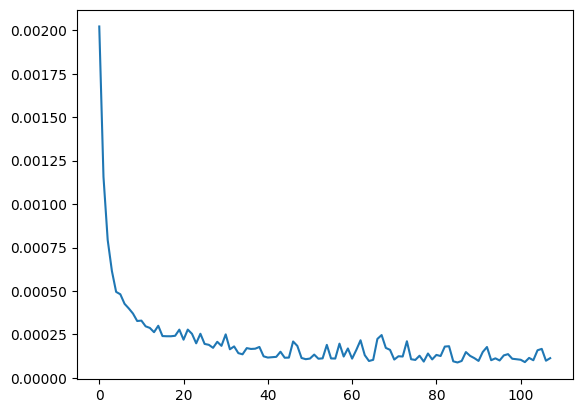

7545/7545 [==============================] - 12s 2ms/step
0.00010763640578520898
0.00010981773994782344
0.006319707943635866
  Hidden_Layer Neurons      Layout Params      MAE      MSE
0            3      32  [8, 16, 8]    362  0.00632  0.00011
Das kleinste Model ist:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 HiddenLayer_1 (Dense)       (None, 8)                 64        
                                                                 
 HiddenLayer_2 (Dense)       (None, 16)                144       
                                                                 
 HiddenLayer_3 (Dense)       (None, 8)                 136       
                                                                 
 OutputLayer (Dense)         (None, 2)                 18        
                                                                 
Total params: 362 (1.41 KB)
Trainable params: 362 (

In [12]:
layer_layout = [[8,16,8]]

s_mse_y = 1000
for layout in layer_layout:
    num_layer = len(layout)
    num_neurons = sum(layout)
    print("Number of Hidden Layers: ",num_layer," Number of Neurons: ", num_neurons)
    temp_model,history = train_model_test(layout)

    y_pred_scaled = temp_model.predict(X_test_scaled)

    num_params = temp_model.count_params()
    mse_y = mean_squared_error(y_test_scaled, y_pred_scaled)
    y_pred_val_scaled = temp_model.predict(X_val_scaled)
    mse_val = mean_squared_error(y_val_scaled, y_pred_val_scaled)
    print(mse_val)
    if (mse_y < s_mse_y):
          s_mse_y = mse_y
          s_model = temp_model
          s_pred = y_pred_scaled
    print(mse_y)
    mae_y = mean_absolute_error(y_test_scaled, y_pred_scaled)
    print(mae_y)

    row = pd.DataFrame([[num_layer, num_neurons,layout, num_params, mae_y, mse_y]], columns=ergebnis_columns)
    ergebnis_df = pd.concat([ergebnis_df, row], ignore_index=True)
print(ergebnis_df)
print("Das kleinste Model ist:")
s_model.summary()
y_pred_scaled = s_pred

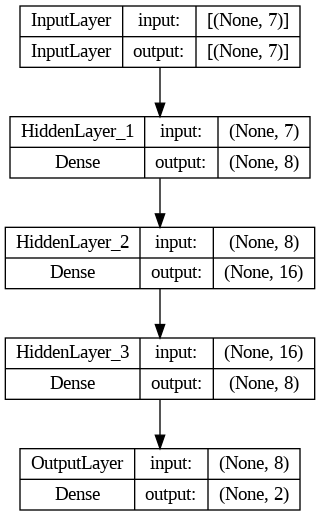

In [13]:
from keras.utils import plot_model
plot_model(temp_model, to_file=folder_path+'model_plot.png', show_shapes=True, show_layer_names=True)

In [14]:
ergebnis_df['Neurons_Total'] = ergebnis_df['Neurons']
edf = ergebnis_df.sort_values(by='Neurons_Total')

# Zeilen mit den kleinsten RMSE-Werten für jeden Wert in 'Neurons_Total' auswählen
min_rmse = edf.loc[edf.groupby('Neurons_Total')['MSE'].idxmin()]

# Neues DataFrame erstellen
pareto_front_temp = min_rmse.reset_index(drop=True)

pareto_front = pd.DataFrame(columns=edf.columns)

mse_temp = 1000
for index, row in pareto_front_temp.iterrows():
    if (row['MSE'] < mse_temp):
      pareto_front = pareto_front.append(row, ignore_index=True)
      mse_temp = row['MSE']
print(ergebnis_df)

print(pareto_front)

  Hidden_Layer Neurons      Layout Params      MAE      MSE Neurons_Total
0            3      32  [8, 16, 8]    362  0.00632  0.00011            32
  Hidden_Layer Neurons      Layout Params      MAE      MSE Neurons_Total
0            3      32  [8, 16, 8]    362  0.00632  0.00011            32


<ipython-input-14-5752792905c8>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pareto_front = pareto_front.append(row, ignore_index=True)


In [15]:
ergebnis_df.to_csv(folder_path + 'ergebnisse_best_1.csv', index=False)

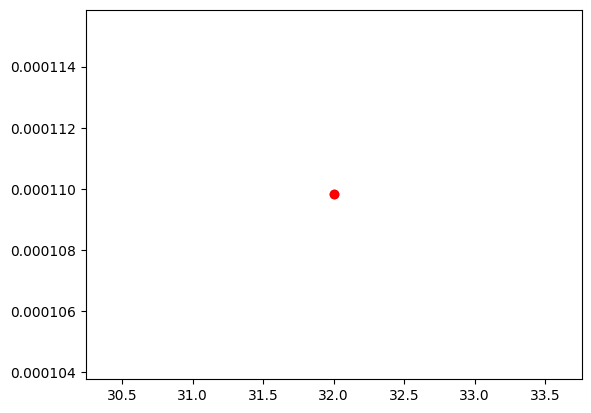

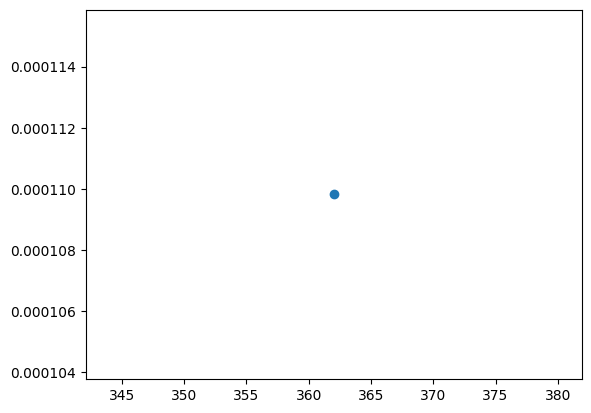

In [16]:
#plt.ylim(0,0.25)
plt.scatter(ergebnis_df['Neurons_Total'],ergebnis_df['MSE'])
plt.scatter(pareto_front['Neurons_Total'],pareto_front['MSE'], color='red')
plt.plot(pareto_front['Neurons_Total'],pareto_front['MSE'], color='red')
plt.show()
#plt.ylim(0,0.25)
plt.scatter(ergebnis_df['Params'],ergebnis_df['MSE'])
plt.show()

In [17]:

y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test.info()
y_pred_df = pd.DataFrame(y_pred, columns=y_columns)
print(meta_test.shape)
print(y_pred_df.shape)

result_columns = list(y_pred_df.columns) + list(meta_test.columns)

y_pred_df.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
meta_test.reset_index(drop=True, inplace=True)

y_pred_df = pd.concat([y_pred_df, meta_test], axis=1, ignore_index=True)
y_test = pd.concat([y_test, meta_test], axis=1, ignore_index=True)
y_test.columns = result_columns
y_pred_df.columns = result_columns

y_test.info()
y_pred_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241420 entries, 512034 to 967375
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Value_SoH    241420 non-null  float64
 1   Value_NcT80  241420 non-null  float64
dtypes: float64(2)
memory usage: 5.5 MB
(241420, 2)
(241420, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241420 entries, 0 to 241419
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Value_SoH    241420 non-null  float64
 1   Value_NcT80  241420 non-null  float64
 2   Value_Age    241420 non-null  int64  
 3   Folder       241420 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 7.4 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241420 entries, 0 to 241419
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Value_SoH    241420 non-null  

In [18]:
#y_pred_df.to_csv(folder_path + 'pred_best.csv', index=False)
y_test.to_csv(folder_path + 'test_best.csv', index=False)

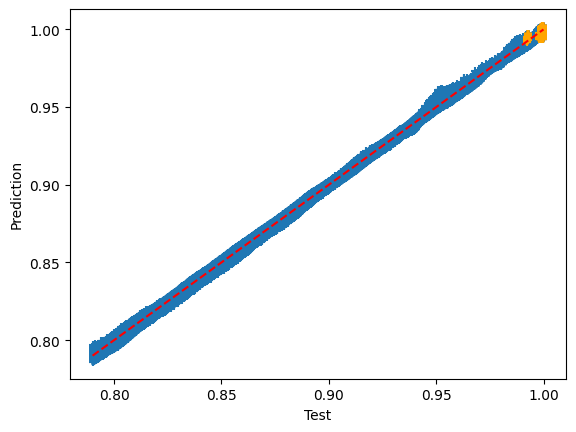

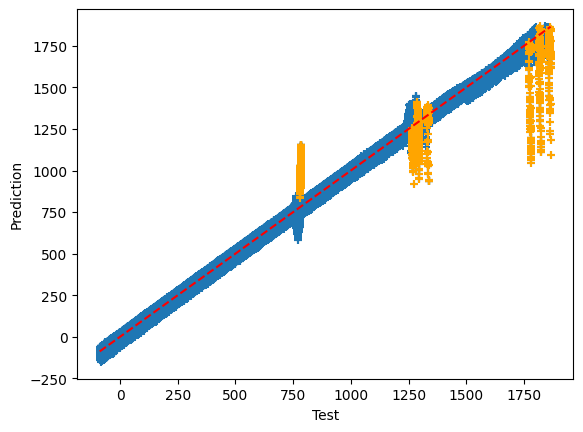

In [19]:
for pred_col in y_columns:
  plt.scatter(y_test[pred_col], y_pred_df[pred_col], marker='+')
  y_test_dayone = y_test[y_test['Value_Age'] < 14]
  y_pred_dayone = y_pred_df[y_pred_df['Value_Age'] < 14]
  plt.scatter(y_test_dayone[pred_col], y_pred_dayone[pred_col], marker='+',color='orange')
  plt.plot([y_test[pred_col].min(), y_test[pred_col].max()], [y_test[pred_col].min(), y_test[pred_col].max()], color='red', linestyle='--')

  plt.xlabel('Test')
  plt.ylabel('Prediction')
  plt.show()


Value_SoH
MSE mean:  1.49605964037162e-06
MSE:  2.0261601485620644e-06


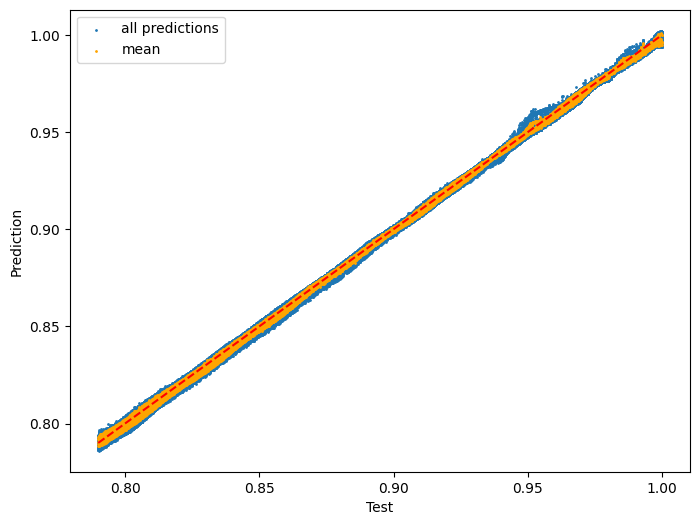

Value_NcT80
MSE mean:  507.64573675472207
MSE:  662.3910777491318


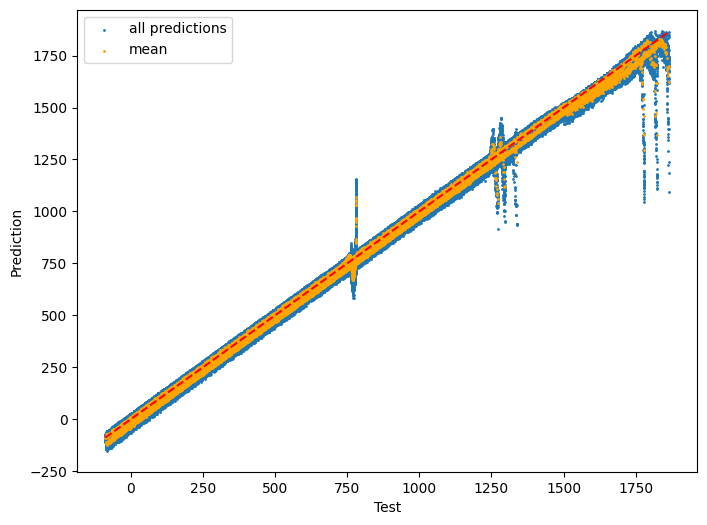

In [20]:
for pred_col in y_columns:
  print(pred_col)
  mean_pred = y_pred_df.groupby(['Folder', 'Value_Age'])[pred_col].mean().reset_index()
  mean_test = y_test.groupby(['Folder', 'Value_Age'])[pred_col].mean().reset_index()
  #mean_pred.info()
  plt.figure(figsize=(8, 6))
  plt.scatter(y_test[pred_col], y_pred_df[pred_col], marker='o',s=1,label='all predictions')
  plt.scatter(mean_test[pred_col], mean_pred[pred_col], marker='o',color='orange',s=1,label='mean')
  plt.plot([y_test[pred_col].min(), y_test[pred_col].max()], [y_test[pred_col].min(), y_test[pred_col].max()], color='red', linestyle='--')
  mse_mean = mean_squared_error(mean_test[pred_col], mean_pred[pred_col])
  mse = mean_squared_error(y_test[pred_col], y_pred_df[pred_col])
  print('MSE mean: ', mse_mean)
  print('MSE: ', mse)
  plt.ylabel('Prediction')
  plt.xlabel('Test')
  plt.legend()
  plt.show()